импорт всех нужных библиотек

In [1]:
import torch
import sys
import os
from model import Trainer,TransformerFuturePrediction
import numpy as np
#путь к корню директории
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.abspath(BASE_DIR))
from data_preparation import PreparationDataset
from show_analysis import LossVisualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Загрузка и подготовка данных для анализа и обучения модели.<br>
разбиение на train,test


In [2]:
path = BASE_DIR + '\data_all'  # Путь к данным
PD = PreparationDataset(path)

# параметры подготовки данных
pd_params = (10,9,25,1)
window_size,num_features,downsample_step,target_window_size = pd_params 

# Подготовка данных
X, y, df = PD.many_to_many(
    window_size,
    num_features,
    downsample_step,
    target_window_size,
    device=device  
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = PD.PDtrain_test_split(
    X, y, test_size=0.33, random_state=42
)

In [7]:
#инициализация модели
hidden_dim = 64
output_dim = 1
num_heads = 4
num_layers = 1
dropout = 0.1
max_seq_len = 32
predict_steps = target_window_size
model = TransformerFuturePrediction( 
    input_dim = X_train.shape[2], # num_features - 1
    hidden_dim = hidden_dim, # hidden_dim%num_heads == 0
    output_dim = output_dim,
    num_heads = num_heads,
    predict_steps = predict_steps,
    num_layers = num_layers,
    max_seq_len = max_seq_len,
    dropout=dropout,
    device = device)
lr = 1e-1
trainer = Trainer(
    model=model,
    learning_rate=lr,
    device= device
)

In [8]:
bs = 64
history = trainer.fit(
    X=X_train,
    y=y_train,
    X_t=X_test,
    y_t=y_test,
    batch_size=bs,
    epochs=2000,
    loss_tube=5
)

Epoch 10
Train - Main: 14720.872532, MAPE: 0.648880 Tube: 0.069289
Test - Main: 14975.236328, MAPE: 0.783802, Tube: 0.060825
Epoch 20
Train - Main: 32875.367281, MAPE: 0.566509 Tube: 0.016806
Test - Main: 32534.234375, MAPE: 0.564301, Tube: 0.017247
Epoch 40
Train - Main: 32799.646075, MAPE: 0.566008 Tube: 0.016816
Test - Main: 32484.824219, MAPE: 0.564021, Tube: 0.017115
Epoch 60
Train - Main: 32803.076342, MAPE: 0.566017 Tube: 0.016855
Test - Main: 32484.542969, MAPE: 0.564020, Tube: 0.017115
Epoch 80
Train - Main: 32794.061771, MAPE: 0.565962 Tube: 0.016878
Test - Main: 32484.460938, MAPE: 0.564019, Tube: 0.017115
Epoch 100
Train - Main: 32804.496775, MAPE: 0.566011 Tube: 0.016794
Test - Main: 32484.437500, MAPE: 0.564019, Tube: 0.017115
Epoch 120
Train - Main: 32795.352628, MAPE: 0.565993 Tube: 0.016751
Test - Main: 32484.410156, MAPE: 0.564019, Tube: 0.017115
Epoch 140
Train - Main: 32802.344678, MAPE: 0.566118 Tube: 0.016673
Test - Main: 32484.404297, MAPE: 0.564019, Tube: 0.0171

KeyboardInterrupt: 

In [8]:
from model_history import ModelHistory
MH = ModelHistory(history)
MH.save_history_json(filename = BASE_DIR+'\loss_history/all_loss.json',model_name = 'Transformer')
key = MH.add_result(
        filename = BASE_DIR+'\\resualt/main.json',
        model_name = 'Transformer',
        result = 'best',
        message = 'first',
        params = {'input_dim': X_train.shape[2], # window_size*num_features - 1
                  'hidden_dim': hidden_dim, # hidden_dim%num_heads == 0
                  'output_dim': output_dim,
                  'num_heads': num_heads,
                  'num_layers': num_layers,
                  'lr':lr,
                  'dropout':dropout,
                  'batch_size':bs}
        )
key

'8b222df5-d0d5-4e58-9ad7-aa6b5cb6387c'

In [11]:
temp_w = torch.load('best_model_weights.pth')

# Проверка, что загруженные веса не равны None
if temp_w is None:
    raise ValueError("Загруженные веса равны None. Проверьте файл весов.")
try:
    model.load_state_dict(temp_w)
    print("Веса успешно загружены и совместимы с текущей моделью.")
except RuntimeError as e:
    print(f"Ошибка при загрузке весов: {e}")

torch.save(temp_w, f'weights/{key}.pth')

Веса успешно загружены и совместимы с текущей моделью.


In [12]:
LV = LossVisualizer(history)

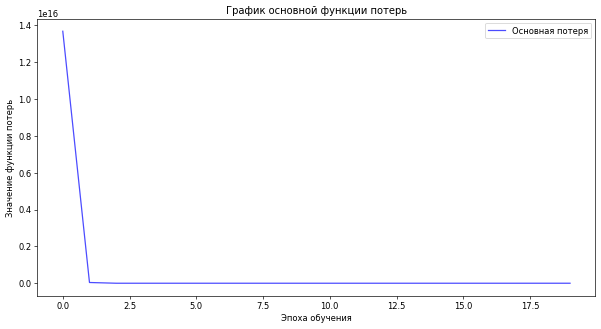

In [13]:
LV.show_training_loss()

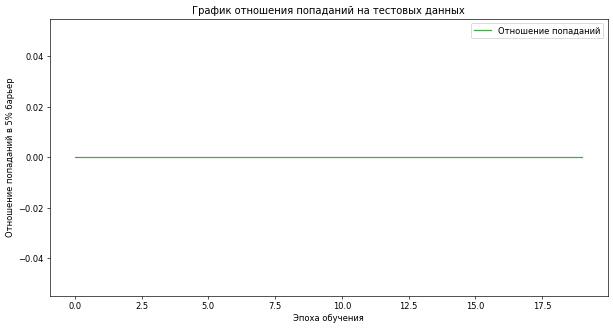

In [14]:
LV.show_test_tube()

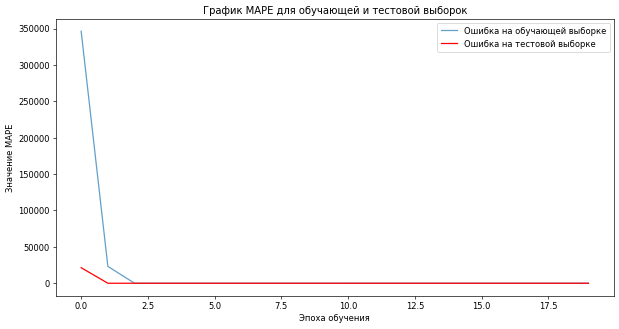

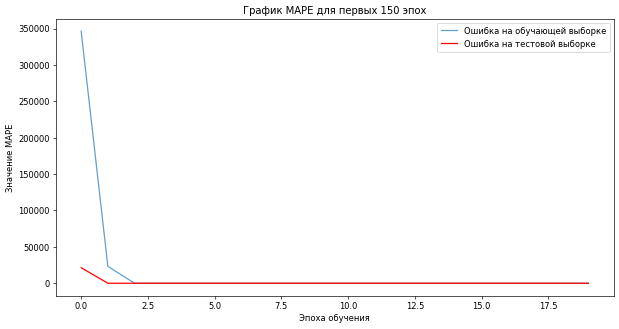

In [15]:
LV.show_mape()

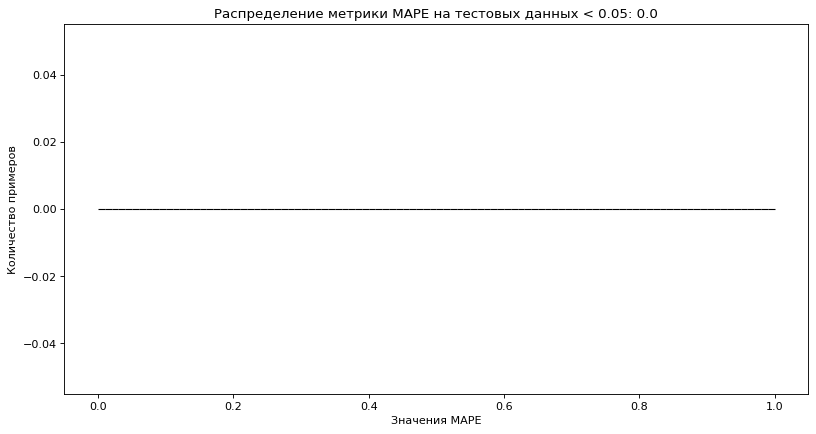

Процент значений MAPE < 0.05: 0.0


In [16]:
LV.histogram_mape(model,X_test,y_test,limit_percel = 5)

Количество записей: 5334


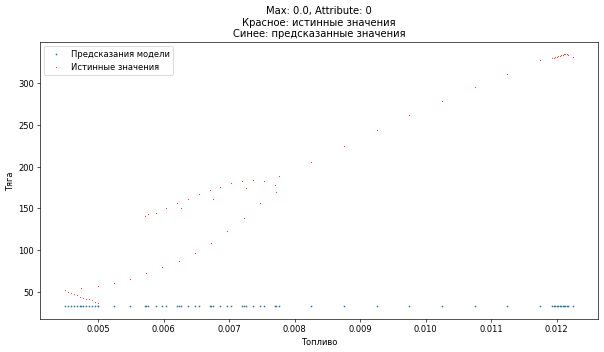

Количество записей: 5334


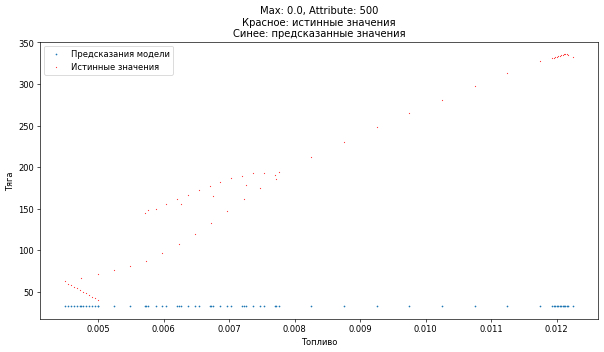

Количество записей: 5334


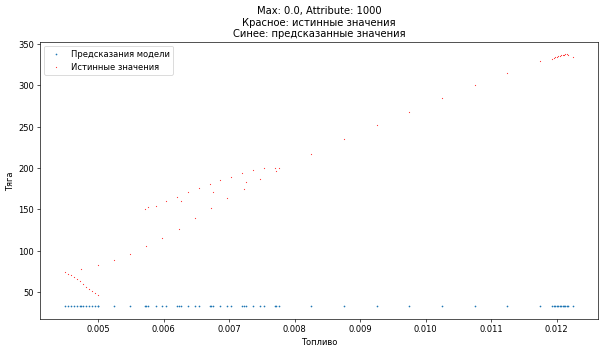

Количество записей: 5334


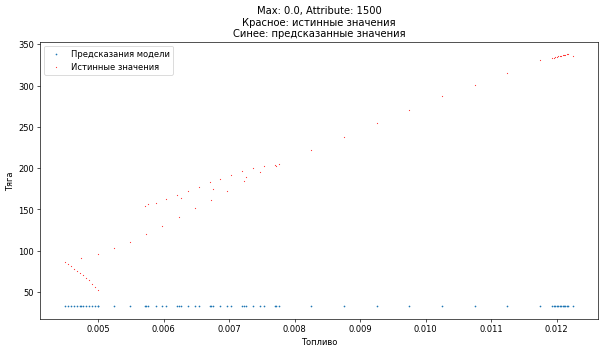

Количество записей: 5334


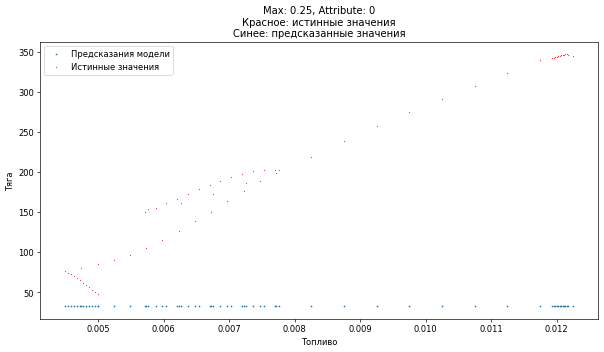

Количество записей: 5334


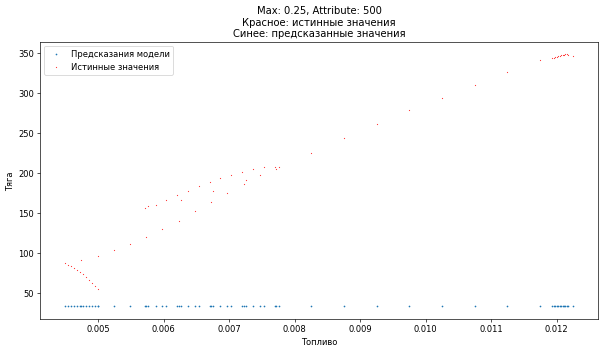

Количество записей: 5334


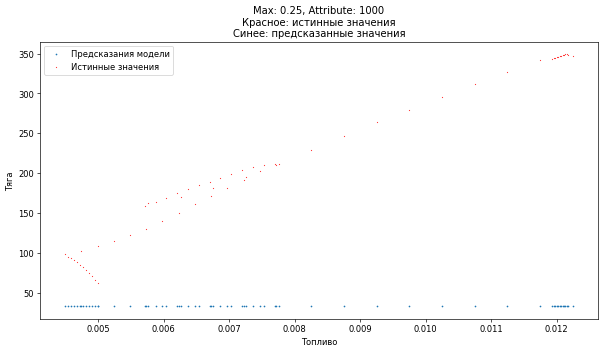

Количество записей: 5334


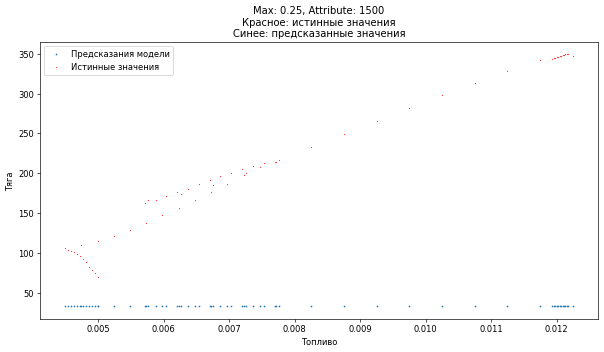

Количество записей: 5334


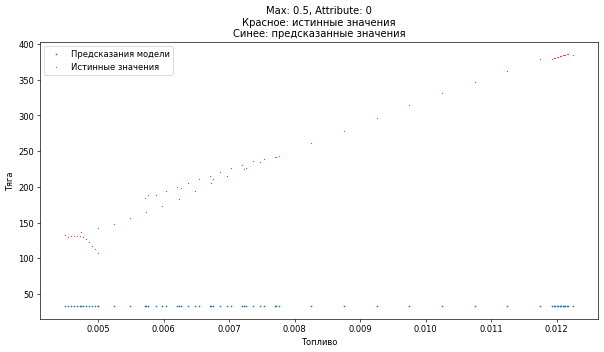

Количество записей: 5334


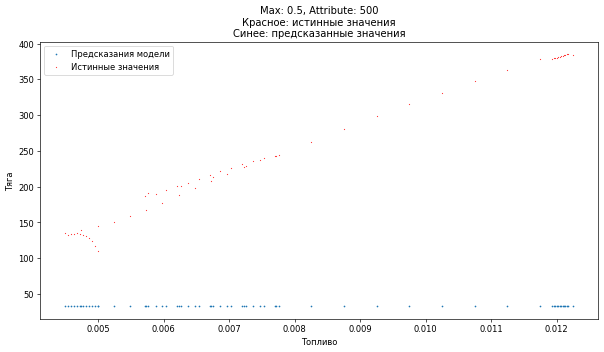

Количество записей: 5334


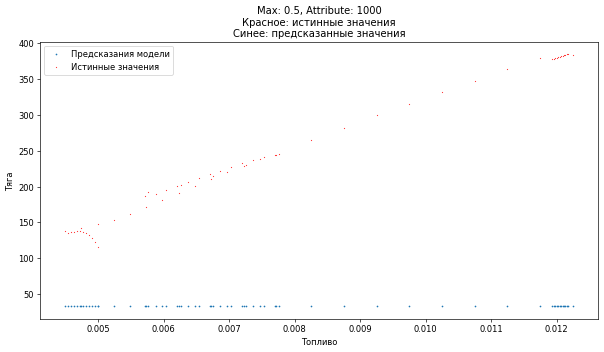

Количество записей: 5334


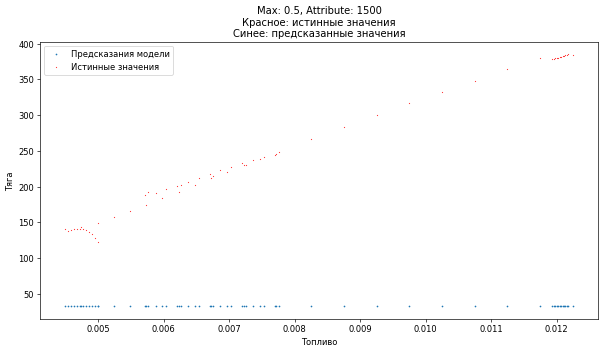

Количество записей: 5334


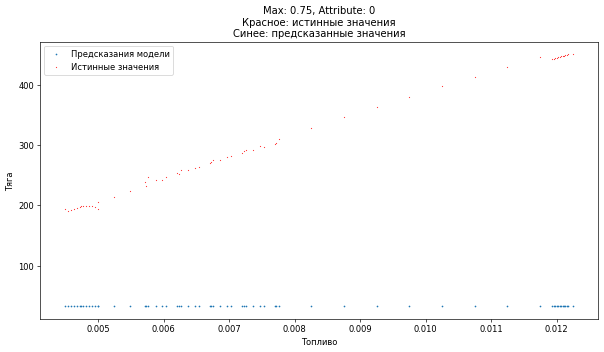

Количество записей: 5334


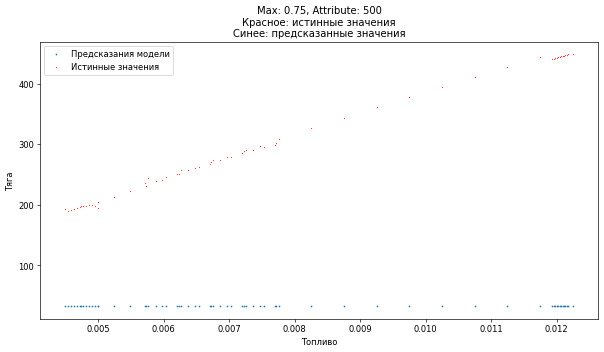

Количество записей: 5334


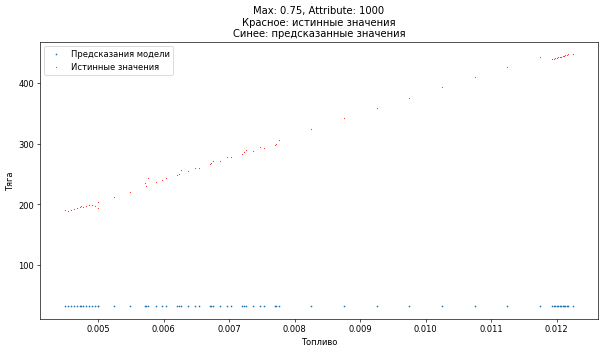

Количество записей: 5334


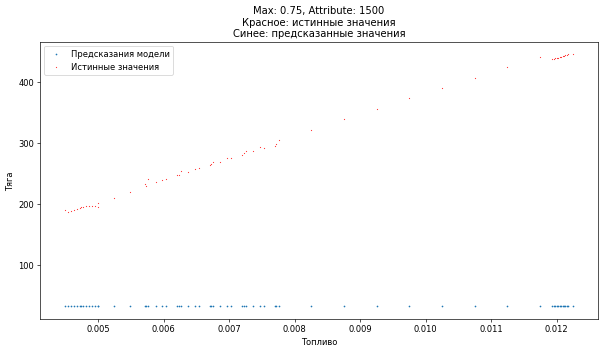

Количество записей: 5334


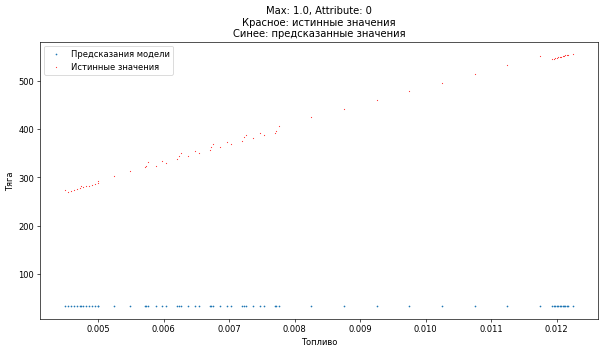

Количество записей: 5334


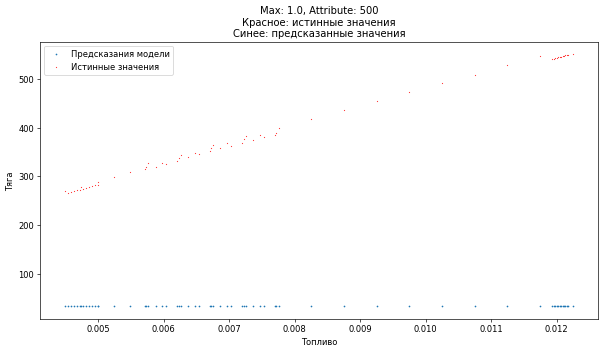

Количество записей: 5334


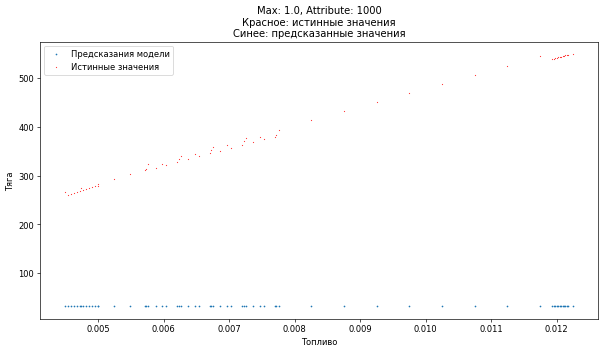

Количество записей: 5334


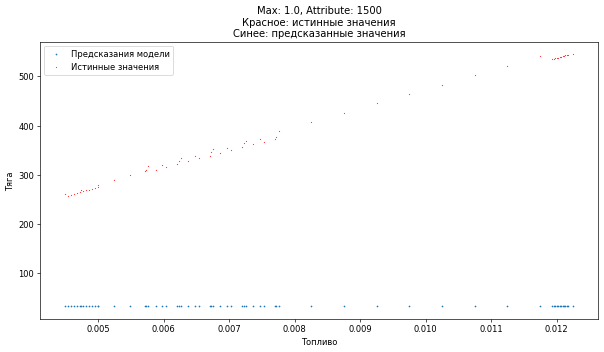

In [17]:
LV.show_predictions_rnn(model,df,pd_params,keras=False,device=device)